# Windfields

This notebook is for downloading typhoon tracks from
IBTrACS and generating the windfields.

TODOs:

- Get the full list of track IDs from IBTraCS (link is below)
- Add interpolation between the timesteps
- Understand if we need to change any of the input parameters
  to the climada methods
- Aggregate up to a 0.1 deg grid and save output

In [7]:
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [39]:
from climada.hazard import Centroids, TCTracks, TropCyclone

In [9]:
help(TCTracks.from_ibtracs_netcdf)

Help on method from_ibtracs_netcdf in module climada.hazard.tc_tracks:

from_ibtracs_netcdf(provider=None, rescale_windspeeds=True, storm_id=None, year_range=None, basin=None, genesis_basin=None, interpolate_missing=True, estimate_missing=False, correct_pres=False, discard_single_points=True, file_name='IBTrACS.ALL.v04r00.nc') method of builtins.type instance
    Create new TCTracks object from IBTrACS databse.
    
    When using data from IBTrACS, make sure to be familiar with the scope and limitations of
    IBTrACS, e.g. by reading the official documentation
    (https://www.ncdc.noaa.gov/ibtracs/pdf/IBTrACS_version4_Technical_Details.pdf). Reading the
    CLIMADA documentation can't replace a thorough understanding of the underlying data. This
    function only provides a (hopefully useful) interface for the data input, but cannot
    provide any guidance or make recommendations about if and how to use IBTrACS data for your
    particular project.
    
    Resulting tracks are req

Mersedeh:

I would browse [here](https://ncics.org/ibtracs/index.php?name=browse-name) 
to create a list of the event IDs that we want. Here I made a start:

In [17]:
typhoon_id_dict = {"GONI": "2020299N11144", "HAIYAN": "2013306N07162"}

In [10]:
# Download all tracks from the west pacific basin
sel_ibtracs = TCTracks.from_ibtracs_netcdf(
    provider="usa", year_range=(2006, 2022), basin="WP"
)

IBTrACS.ALL.v04r00.nc: 26.5MB [00:09, 2.66MB/s]                                              


2022-11-15 10:02:19,307 - climada.hazard.tc_tracks - WARNING - 18 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


In [15]:
# Look at how many tracks there are - there are a lot
sel_ibtracs.size

494

In [55]:
# Loop through the typhoons
tc_tracks = TCTracks()
for typhoon_name, typhoon_id in typhoon_id_dict.items():
    tc_track = sel_ibtracs.get_track(typhoon_id)
    # TODO: We need to add a step here that interpolates the timesteps
    tc_tracks.append(tc_track)

<GeoAxesSubplot:>

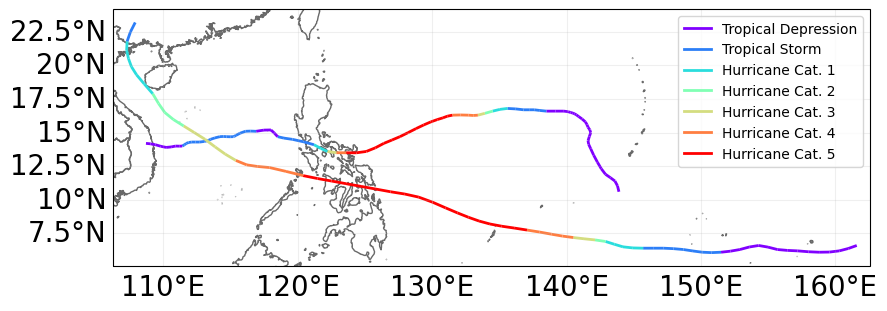

In [56]:
# Plot the tracks
tc_tracks.plot()

In [57]:
# Then calculate windfield

In [58]:
help(TropCyclone.from_tracks)

Help on method from_tracks in module climada.hazard.trop_cyclone:

from_tracks(tracks, centroids=None, pool=None, description='', model='H08', ignore_distance_to_coast=False, store_windfields=False, metric='equirect', intensity_thres=17.5) method of builtins.type instance
    Create new TropCyclone instance that contains windfields from the specified tracks.
    
    This function sets the `intensity` attribute to contain, for each centroid,
    the maximum wind speed (1-minute sustained winds at 10 meters above ground) experienced
    over the whole period of each TC event in m/s. The wind speed is set to 0 if it doesn't
    exceed the threshold `intensity_thres`.
    
    The `category` attribute is set to the value of the `category`-attribute
    of each of the given track data sets.
    
    The `basin` attribute is set to the genesis basin for each event, which
    is the first value of the `basin`-variable in each of the given track data sets.
    
    Optionally, the time depend

2022-11-15 10:36:46,706 - climada.util.plot - WARNING - Error parsing coordinate system 'EPSG:4326'. Using projection PlateCarree in plot.


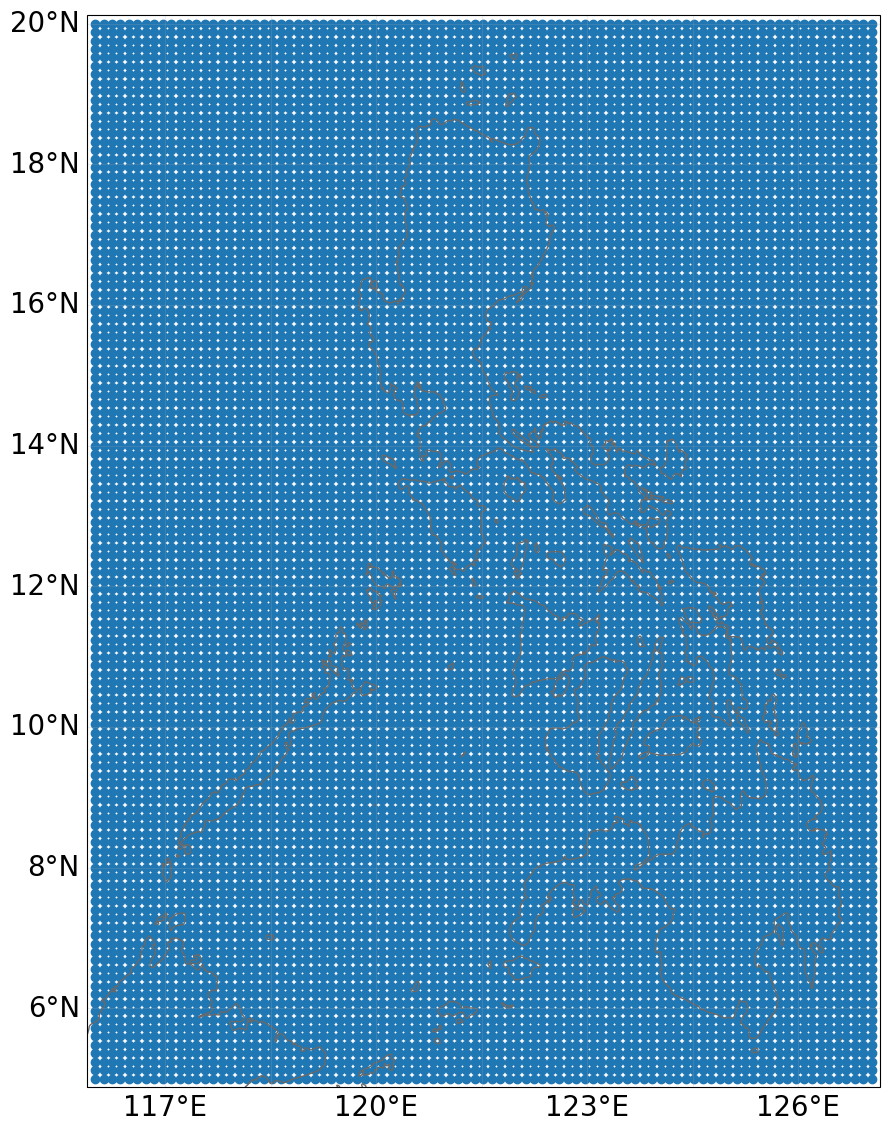

In [44]:
# construct centroids
min_lat, max_lat, min_lon, max_lon = 5.0, 20.0, 116.0, 127.0  # TODO: Adjust
cent = Centroids.from_pnt_bounds(
    (min_lon, min_lat, max_lon, max_lat), res=0.12
)
cent.check()
cent.plot();

In [52]:
# construct tropical cyclones
tc = TropCyclone.from_tracks(tc_tracks, centroids=cent, store_windfields=True)

2022-11-15 10:43:27,074 - climada.util.plot - WARNING - Error parsing coordinate system 'EPSG:4326'. Using projection PlateCarree in plot.


<GeoAxesSubplot:title={'center':'Event ID 1: 2020299N11144'}>

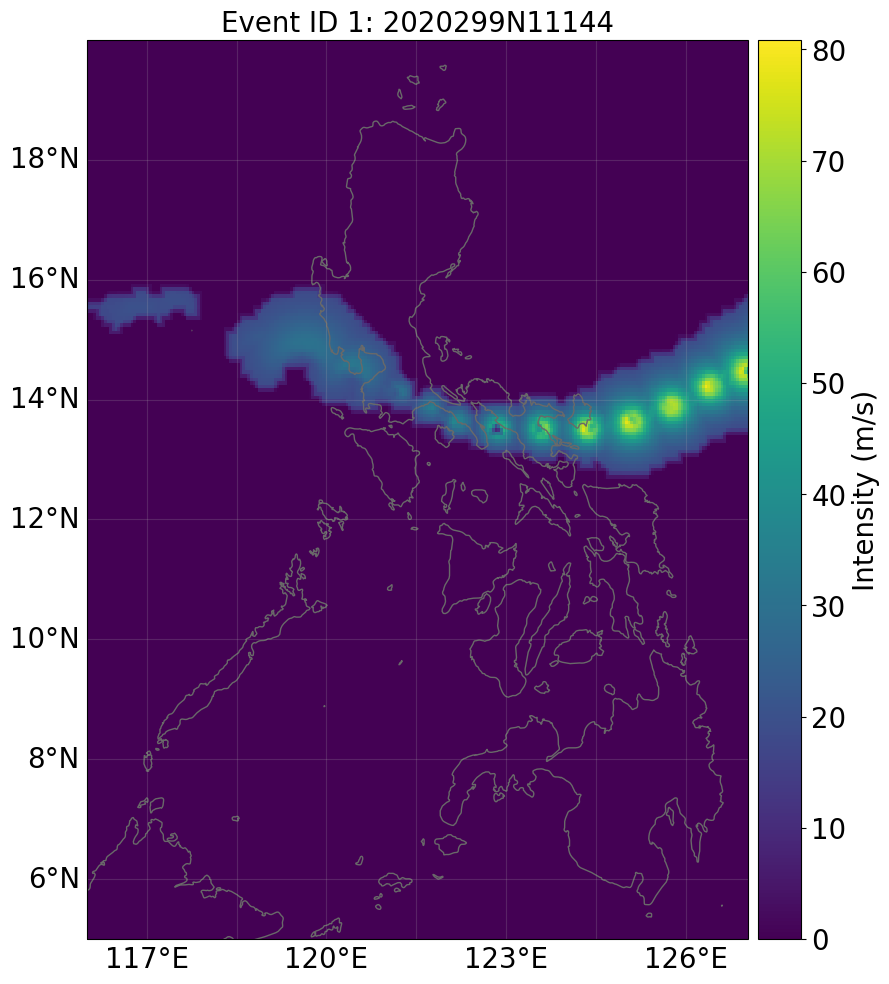

In [59]:
# Let's look at Goni as an example. For now
# it's clear that we will need to interpolate the timesteps.
tc.plot_intensity(typhoon_id_dict["GONI"])